In [1]:
from ipywidgets import IntProgress
from IPython.display import display
import time

from covid19_vulnerabilidad_mex.datos import *
from covid19_vulnerabilidad_mex.vulnerabilidad import *

import pandas as pd
import geopandas as gpd

import glob
import os
import matplotlib.pyplot as plt
import numpy as np

from datetime import timedelta
import datetime
from datetime import timedelta, date, datetime
import pickle

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_decomposition import PLSRegression

import seaborn as sns
import imageio
from pygifsicle import optimize

plt.style.use('ggplot')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
fecha_corte = datetime.strptime('9-03-21', "%d-%m-%y").date()
antier = fecha_corte - timedelta(days=2)
fecha_analisis = antier - timedelta(weeks=2)
fecha_analisis = pd.to_datetime(fecha_analisis)
metodo = 'PLS'
ventana_dias = 28
inicio = pd.to_datetime('20-03-15', yearfirst=True)
fin = antier - timedelta(days=7)
# leemos los datos de un pickle ya calculado para el dia de fecha_corte
serie_municipal = pickle.load( open( "datos/serie_municipal_reclasificada_9-03-21.pkl", "rb" ) )
modelos, serie = periodo_vulnerabilidad_con_dataframe(
            serie_municipal,
            inicio,
            fin,
            min_casos=10,
            columna='covid_defun_100k',
            rf=False
        )

IntProgress(value=0, max=350)

In [ ]:
### CORRER ESTA SÓLO SI NO SE UTILIZA UN PICKLE ##

# serie_municipal = serie_covid_indicadores_municipales(antier.strftime('%y%m%d'),
#                                                       acumulativa=False,
#                                                       dias=ventana_dias,
#                                                       indicadores='datos/municipios/indicadores_reclasificados.csv')
# serie_municipal[['conteo', 'defunciones']] = serie_municipal[[f'conteo_{ventana_dias}dias',
#                                                               f'defunciones_{ventana_dias}dias']]
# serie_municipal = serie_municipal.drop(columns=[f'conteo_{ventana_dias}dias',
#                                    f'defunciones_{ventana_dias}dias'])                                                              
# serie_municipal = agregar_tasas_municipales(serie_municipal)

/home/datalab/app/covid19_vulnerabilidad_mex/datos.py:242: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['SEMANA_AÑO_INGRESO'] = df.index.week


In [ ]:
# modelos, serie = periodo_vulnerabilidad_con_dataframe(
#             serie_municipal,
#             inicio,
#             fin,
#             min_casos=10,
#             columna='covid_defun_100k',
#             rf=False
#         )
# serie = agregar_vulnerabilidad_entidades(serie, 'valor_covid_defun_100k')
# modelos['coef'] = modelos['coef'].abs()

IntProgress(value=0, max=352)

<AxesSubplot:xlabel='FECHA_INGRESO', ylabel='valor_covid_defun_100k'>

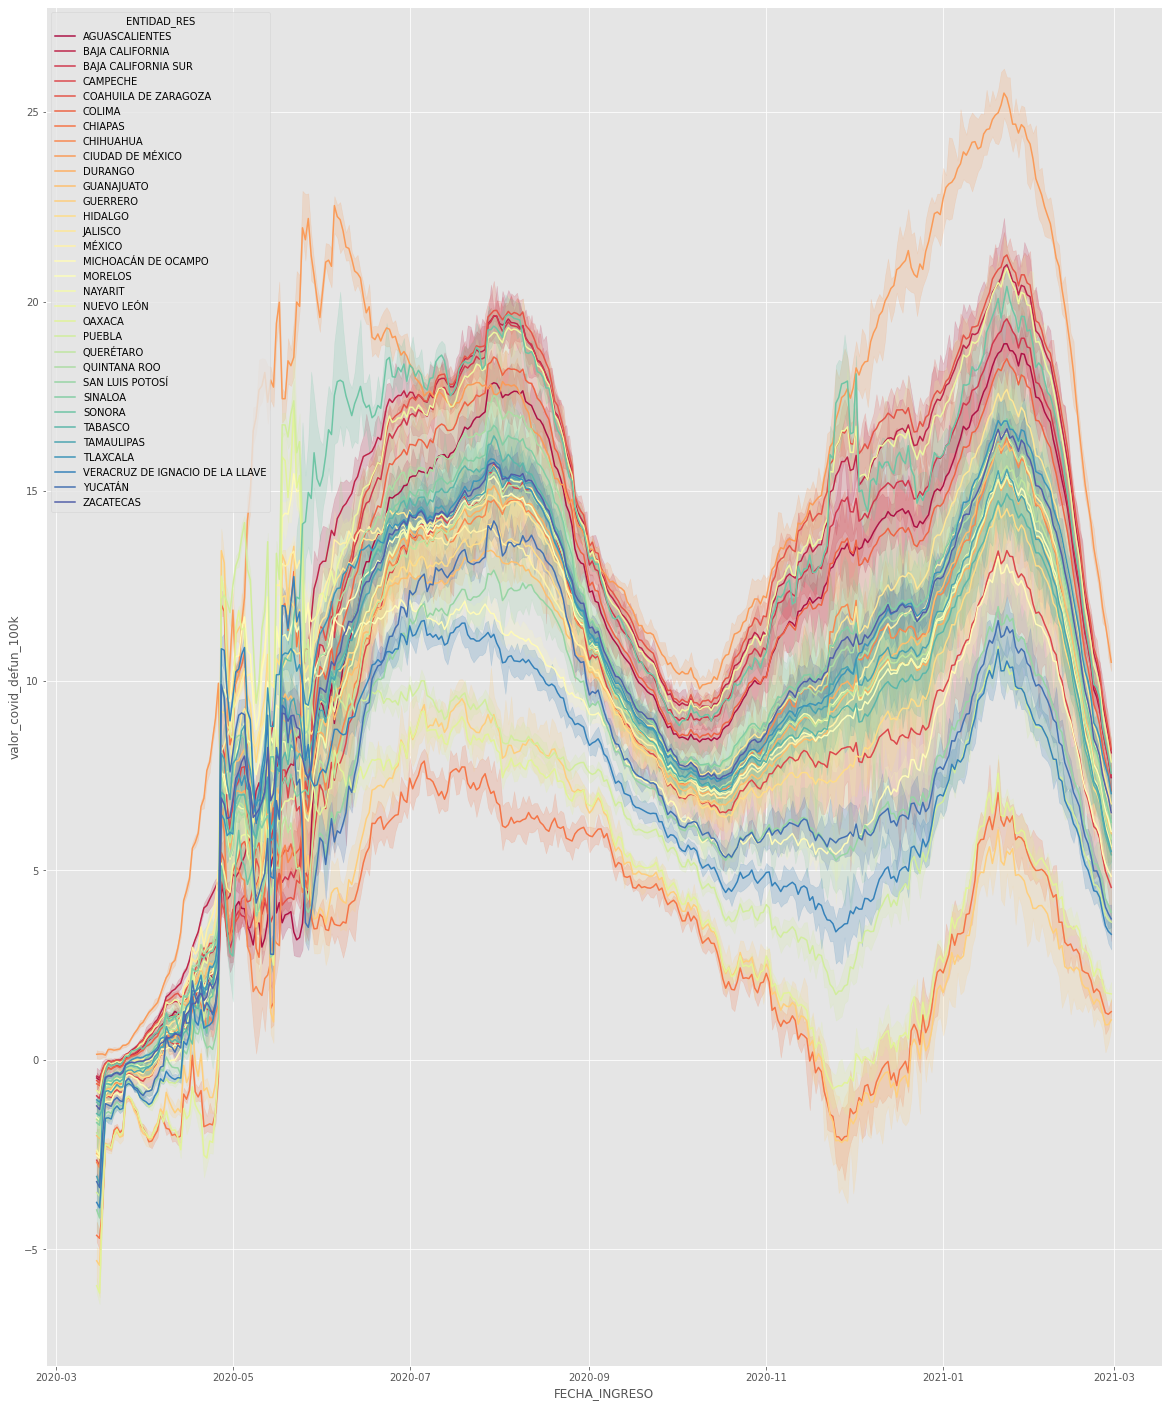

In [4]:
fig, ax = plt.subplots(figsize=(20, 25))
sns.lineplot(data=serie,
             x='FECHA_INGRESO', y=f'valor_covid_defun_100k',
             hue='ENTIDAD_RES', palette='Spectral',
             n_boot=10)

# Análisis temporal

Con las series de vulnerabilidad y modelos ajustadas al 9 de marzo vamos a hacer un análisis de la variación temporal de la vulnerabilidad. El análisisis se va a centrar en dos ideas:

* ¿Cómo cambia la vulnerabilidad relativa de estados y municipios en el tiempo?
* ¿Cómo cambia la importancia relativa de los parámetros?

Como primera aproximación, en lugar de comparar las series de tiempo completas, vamos a utilizar cortes de tiempo definidos a partir de momentos importantes en la pandemia:

* Antes del inicio de la jornada de sana distancia (23 de marzo 2020)
* A la mitad de la jornada (30 de abril)
* Al finalizar la jornada (30 de mayo)
* Alrededor del pico de casos (1 de agosto)
* En el punto más bajo (15 de octubre)
* A mitad del camino entre este punto y el segundo pico (1 de diciembre)
* En el segundo pico (20 de enero de 2021)
* Actualmente (valor de la variable `fin`)

In [ ]:
fechas = [pd.to_datetime('20-03-23', yearfirst=True),
          pd.to_datetime('20-04-30', yearfirst=True),
          pd.to_datetime('20-05-30', yearfirst=True),
          pd.to_datetime('20-08-01', yearfirst=True),
          pd.to_datetime('20-10-15', yearfirst=True),
          pd.to_datetime('20-12-01', yearfirst=True),
          pd.to_datetime('21-01-20', yearfirst=True),
          pd.to_datetime(fin.strftime('%y-%m-%d'), yearfirst=True),]
serie_momentos = serie[serie.FECHA_INGRESO.isin(fechas)]
modelos_momentos = modelos[modelos.dia_ajuste.isin(fechas)]

## Evolución de la vulnerabilidad por estado

Para entender la evolución de la vulonerabilidad a nivel estatal vamos a graficar la dinámica del ranking de vulnerabilidad sobre los estados

<AxesSubplot:xlabel='FECHA_INGRESO', ylabel='valor_covid_defun_100k_entidad'>

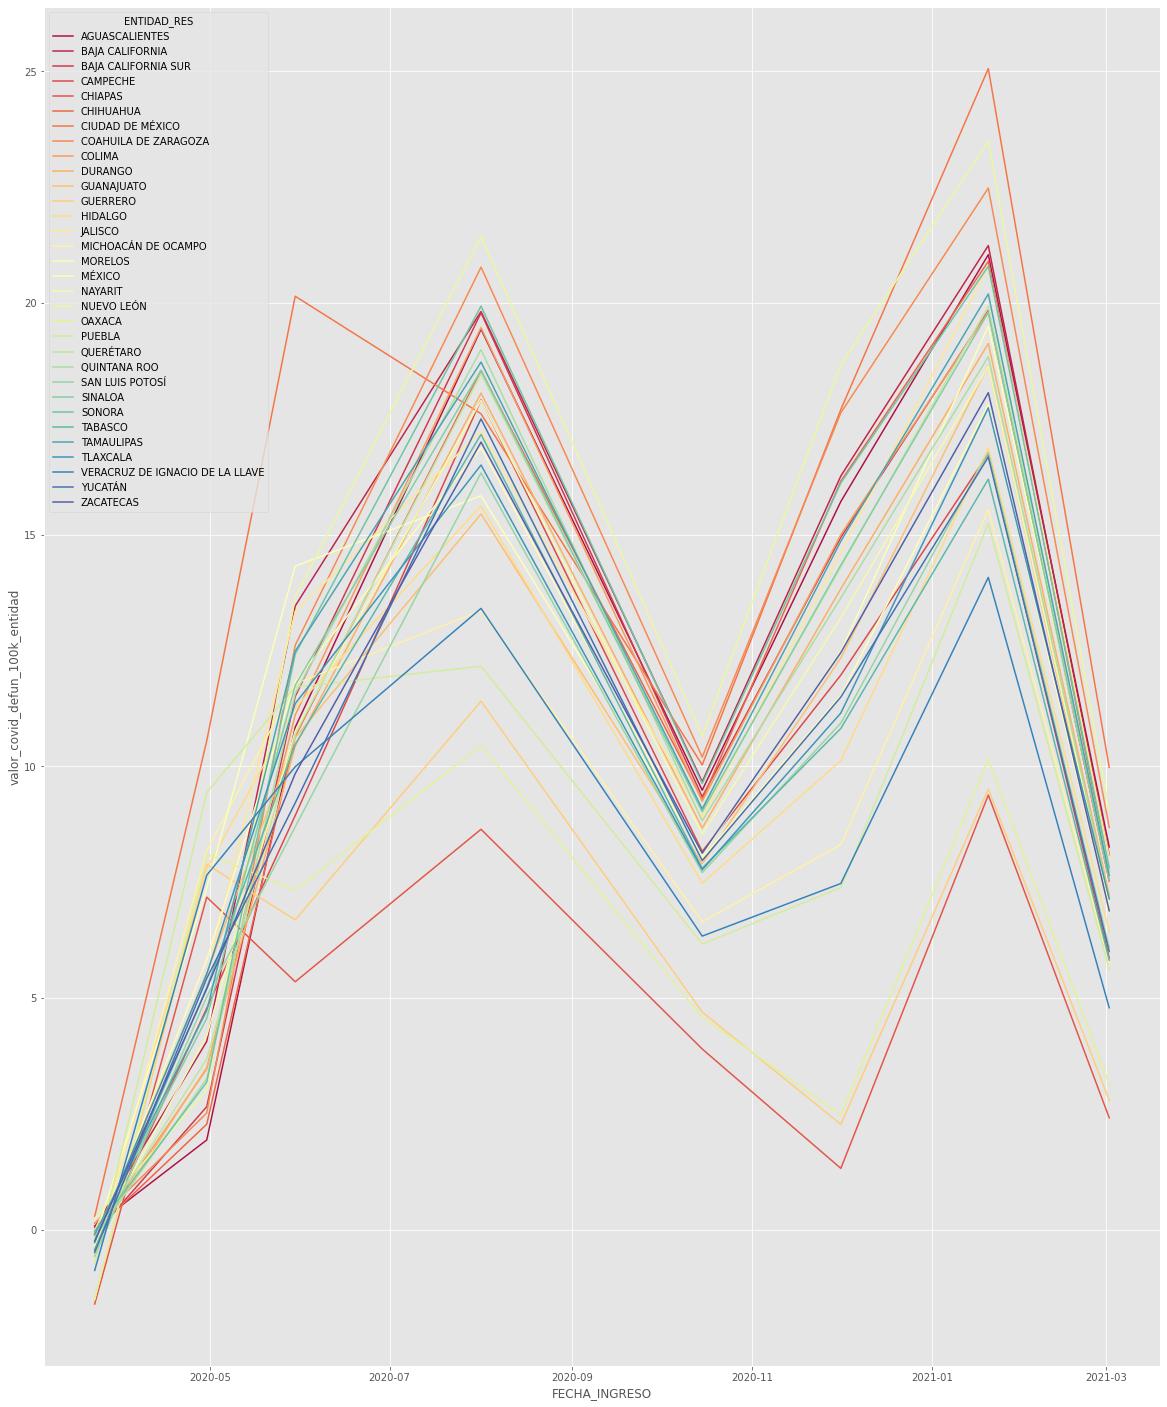

In [ ]:
entidad_momentos = (serie_momentos[["ENTIDAD_RES", "FECHA_INGRESO", "valor_covid_defun_100k_entidad"]]
                    .groupby(["ENTIDAD_RES", "FECHA_INGRESO"])['valor_covid_defun_100k_entidad']
                    .mean()
                    .reset_index()
                    )
fig, ax = plt.subplots(figsize=(20, 25))
sns.lineplot(data=entidad_momentos,
             x='FECHA_INGRESO', y=f'valor_covid_defun_100k_entidad',
             hue='ENTIDAD_RES', palette='Spectral')

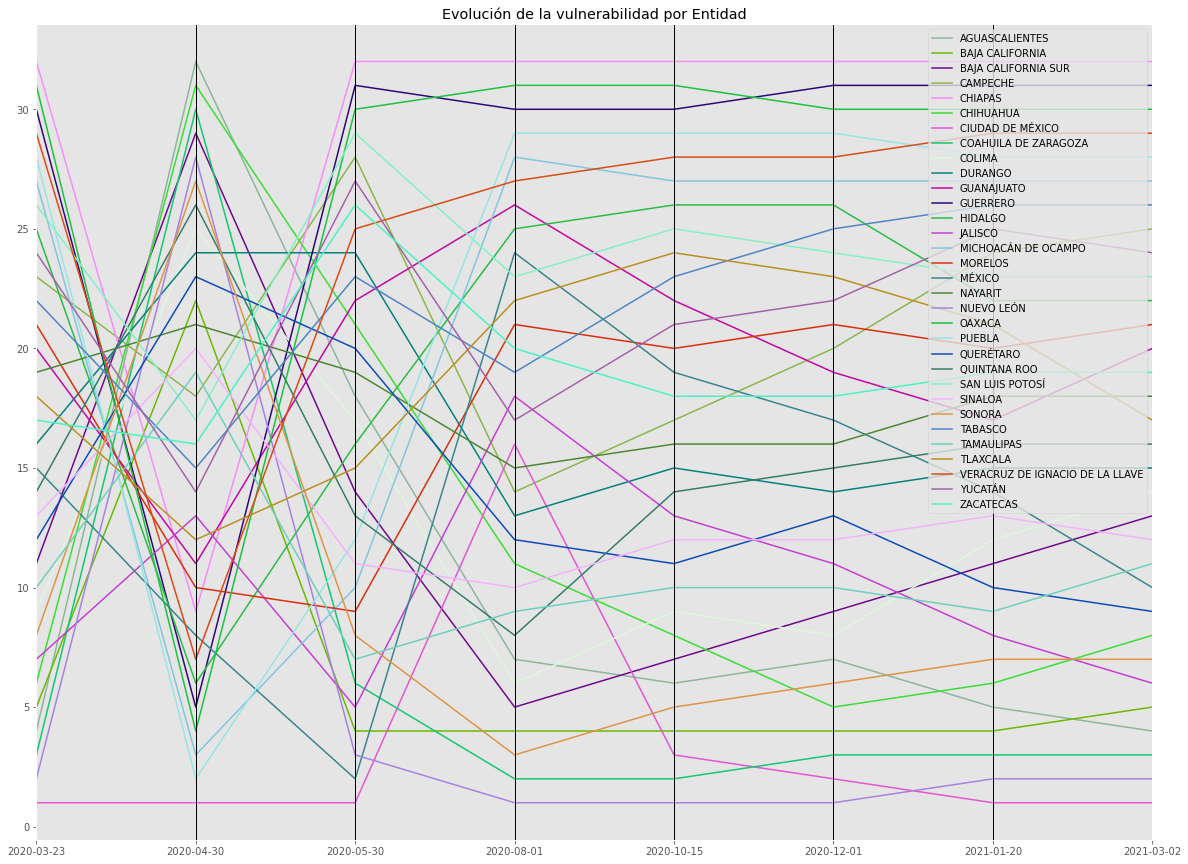

In [ ]:
entidad_momentos = (entidad_momentos
                    .pivot(index='ENTIDAD_RES', 
                          columns='FECHA_INGRESO', 
                          values='valor_covid_defun_100k_entidad')
                )
ranking_entidades = entidad_momentos.rank(ascending=False)
new_cols = [c.strftime('%Y-%m-%d') if isinstance(c, datetime) else c for c in ranking_entidades.reset_index().columns]
parallel_data = ranking_entidades.reset_index()
parallel_data.columns = new_cols
fig, ax = plt.subplots(figsize=(20, 15))
p = pd.plotting.parallel_coordinates(parallel_data, "ENTIDAD_RES")
p.set_title("Evolución de la vulnerabilidad por Entidad")
plt.savefig('img/evolucion_vulnerabilidad_entidad.png', bbox_inches='tight')

### Evolución de la vulnerabilidad promedio

Hasta aquí lo que calculamos fue la evolución de la vulnerabilidad medida en cada uno de los momentos, ahora vamos a calcular el promedio entre los momentos y ver cómo evoluciona este.

Esto puede ser importante porque siempre va a haber una componente aleatoria en la variación, entonces la vulnerabilidad medida en los puntos exactos puede no decir todo lo que buscamos.

<AxesSubplot:xlabel='intervalo', ylabel='media_intervalo'>

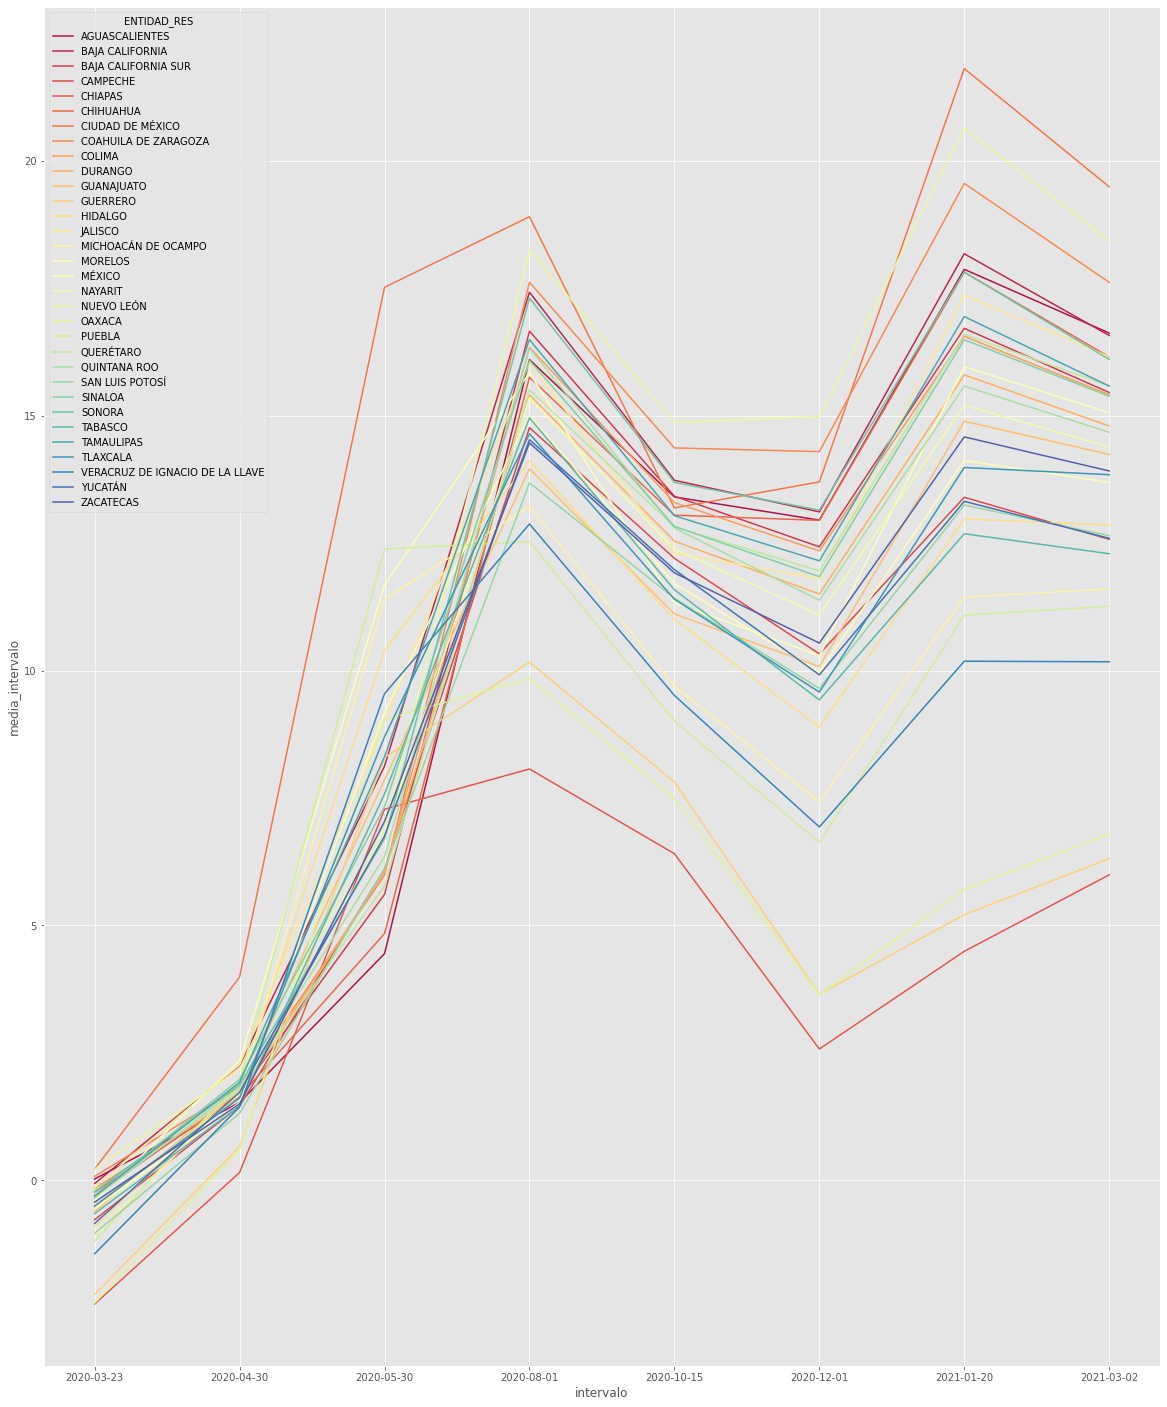

In [ ]:
for i, fecha in enumerate(fechas):
    if i == 0:
        serie.loc[serie.FECHA_INGRESO <= fecha, 'intervalo'] = fecha.strftime('%Y-%m-%d')
    else:
        serie.loc[(serie.FECHA_INGRESO > fechas[i-1]) & (serie.FECHA_INGRESO <= fecha), 'intervalo'] = fecha.strftime('%Y-%m-%d') 
serie['media_intervalo'] = (serie
                            .groupby(['intervalo', 'ENTIDAD_RES'])['valor_covid_defun_100k_entidad']
                            .transform('mean')
                            )
serie_momentos = serie[serie.FECHA_INGRESO.isin(fechas)]
entidad_momentos = (serie_momentos[["ENTIDAD_RES", "intervalo", "media_intervalo"]]
                    .groupby(["ENTIDAD_RES", "intervalo"])['media_intervalo']
                    .mean()
                    .reset_index()
                    )
fig, ax = plt.subplots(figsize=(20, 25))
sns.lineplot(data=entidad_momentos,
             x='intervalo', y=f'media_intervalo',
             hue='ENTIDAD_RES', palette='Spectral')                            

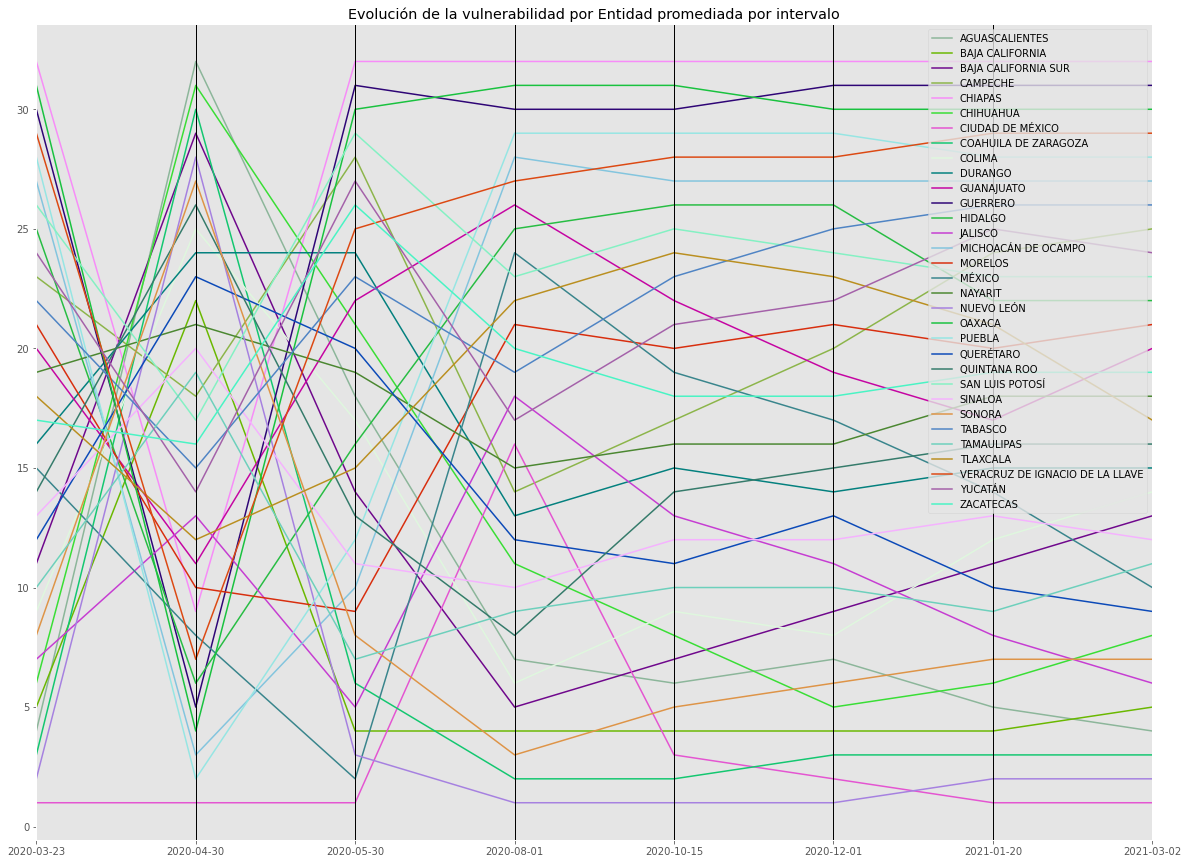

In [ ]:
entidad_momentos_wide = (entidad_momentos
                       .pivot(index='ENTIDAD_RES', 
                              columns='intervalo', 
                              values='media_intervalo')
                      )
ranking_entidades = entidad_momentos_wide.rank(ascending=False)
new_cols = [c.strftime('%Y-%m-%d') if isinstance(c, datetime) else c for c in ranking_entidades.reset_index().columns]
ranking_entidades = ranking_entidades.reset_index()
ranking_entidades.columns = new_cols
fig, ax = plt.subplots(figsize=(20, 15))
p = pd.plotting.parallel_coordinates(parallel_data, "ENTIDAD_RES")
p.set_title("Evolución de la vulnerabilidad por Entidad promediada por intervalo")
plt.savefig('img/evolucion_vulnerabilidad_entidad_promedio.png', bbox_inches='tight')

## Evolución de la importancia de las variables

Para entender la dinámicva de la importancia de las variables vamos a hacer lo mismo que para la vulnerabilidad por estado.

Primero vamos a capturar las importancias _instantáneas_ en cada momento, después vamos a promediar los valores sobre cada intervalo.

Como el signo de los coeficientes sólo indica la dirección de rotación, vamos a tomar el valor absoluto para ver su evolución

### Parallel Plot

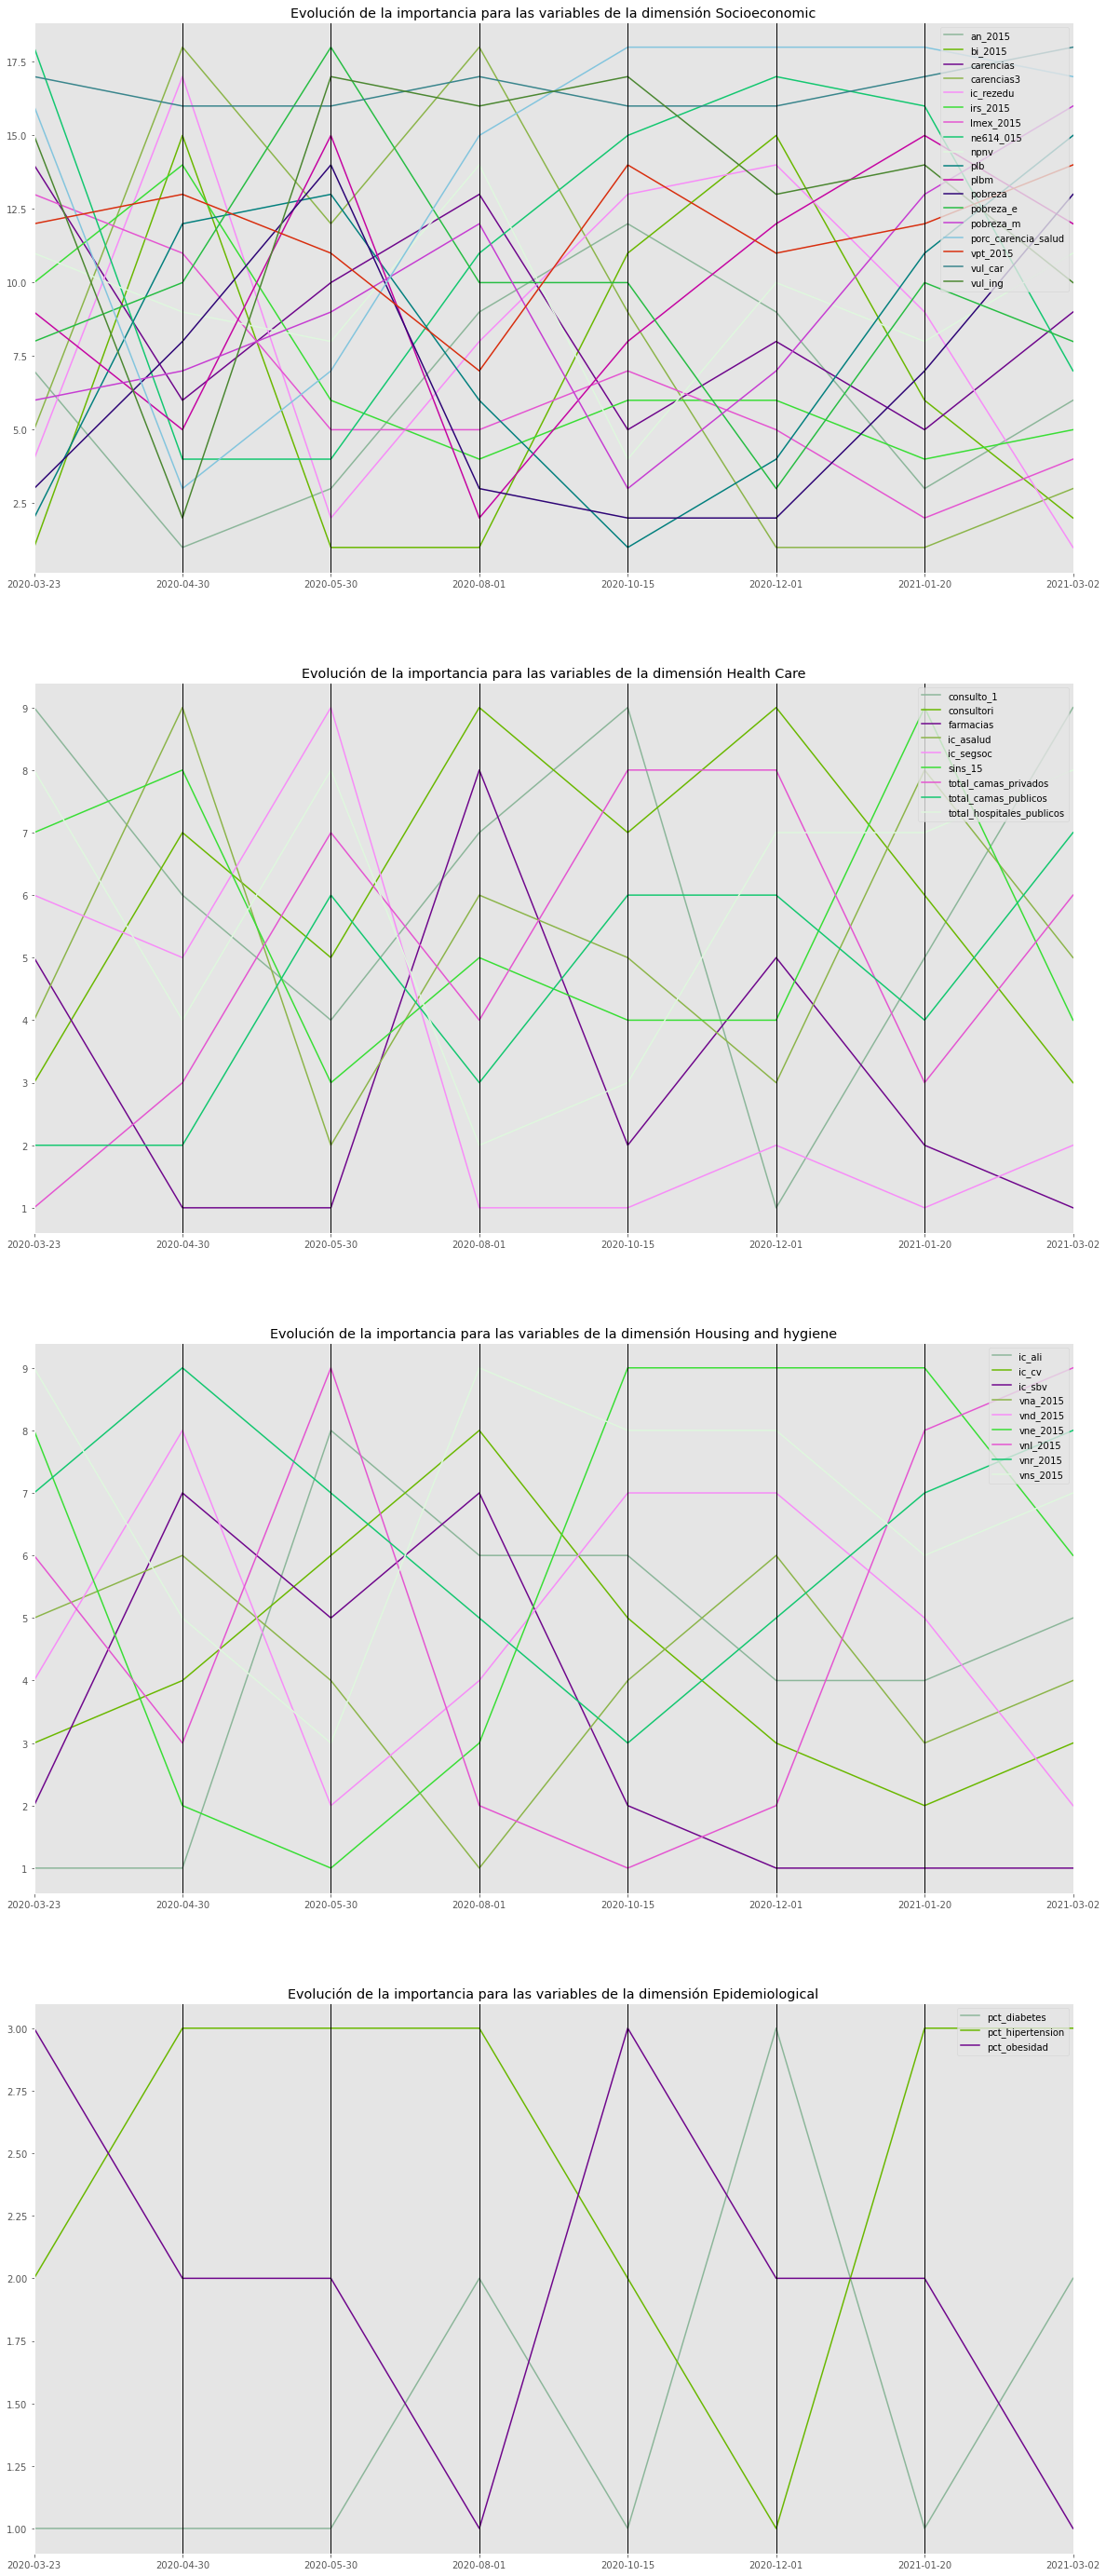

In [ ]:
modelos_momentos = modelos[modelos.dia_ajuste.isin(fechas)]
dimensiones = pd.read_csv("datos/diccionario_variables_usadas.csv")
modelos_momentos = modelos_momentos.merge(dimensiones, left_on='caracteristica', right_on='campo').drop(columns=['campo', 'descriptor'])
modelos_momentos_wide = (modelos_momentos
                    .pivot(index=['caracteristica', 'dimension'],
                           columns='dia_ajuste',
                           values='coef')
                    )
ranking_variables = (modelos_momentos_wide
                     .groupby('dimension')
                     .rank(ascending=False)
                     .reset_index()
                     )
new_cols = [c.strftime('%Y-%m-%d') if isinstance(c, datetime)
            else c for c in ranking_variables.columns]
ranking_variables.columns = new_cols
f, axes = plt.subplots(4,figsize=(20, 50))
lista_dimensiones = ranking_variables.dimension.unique()
for i, ax in enumerate(axes):
    datos = ranking_variables[ranking_variables.dimension == lista_dimensiones[i]]
    f = pd.plotting.parallel_coordinates(datos.drop(columns="dimension"),
                                         "caracteristica",
                                         ax=ax)
    f.set_title(f'Evolución de la importancia para las variables de la dimensión {lista_dimensiones[i]}')
plt.savefig('img/evolucion_caracteristicas_por_dimension.png', bbox_inches='tight')

### Heatmap

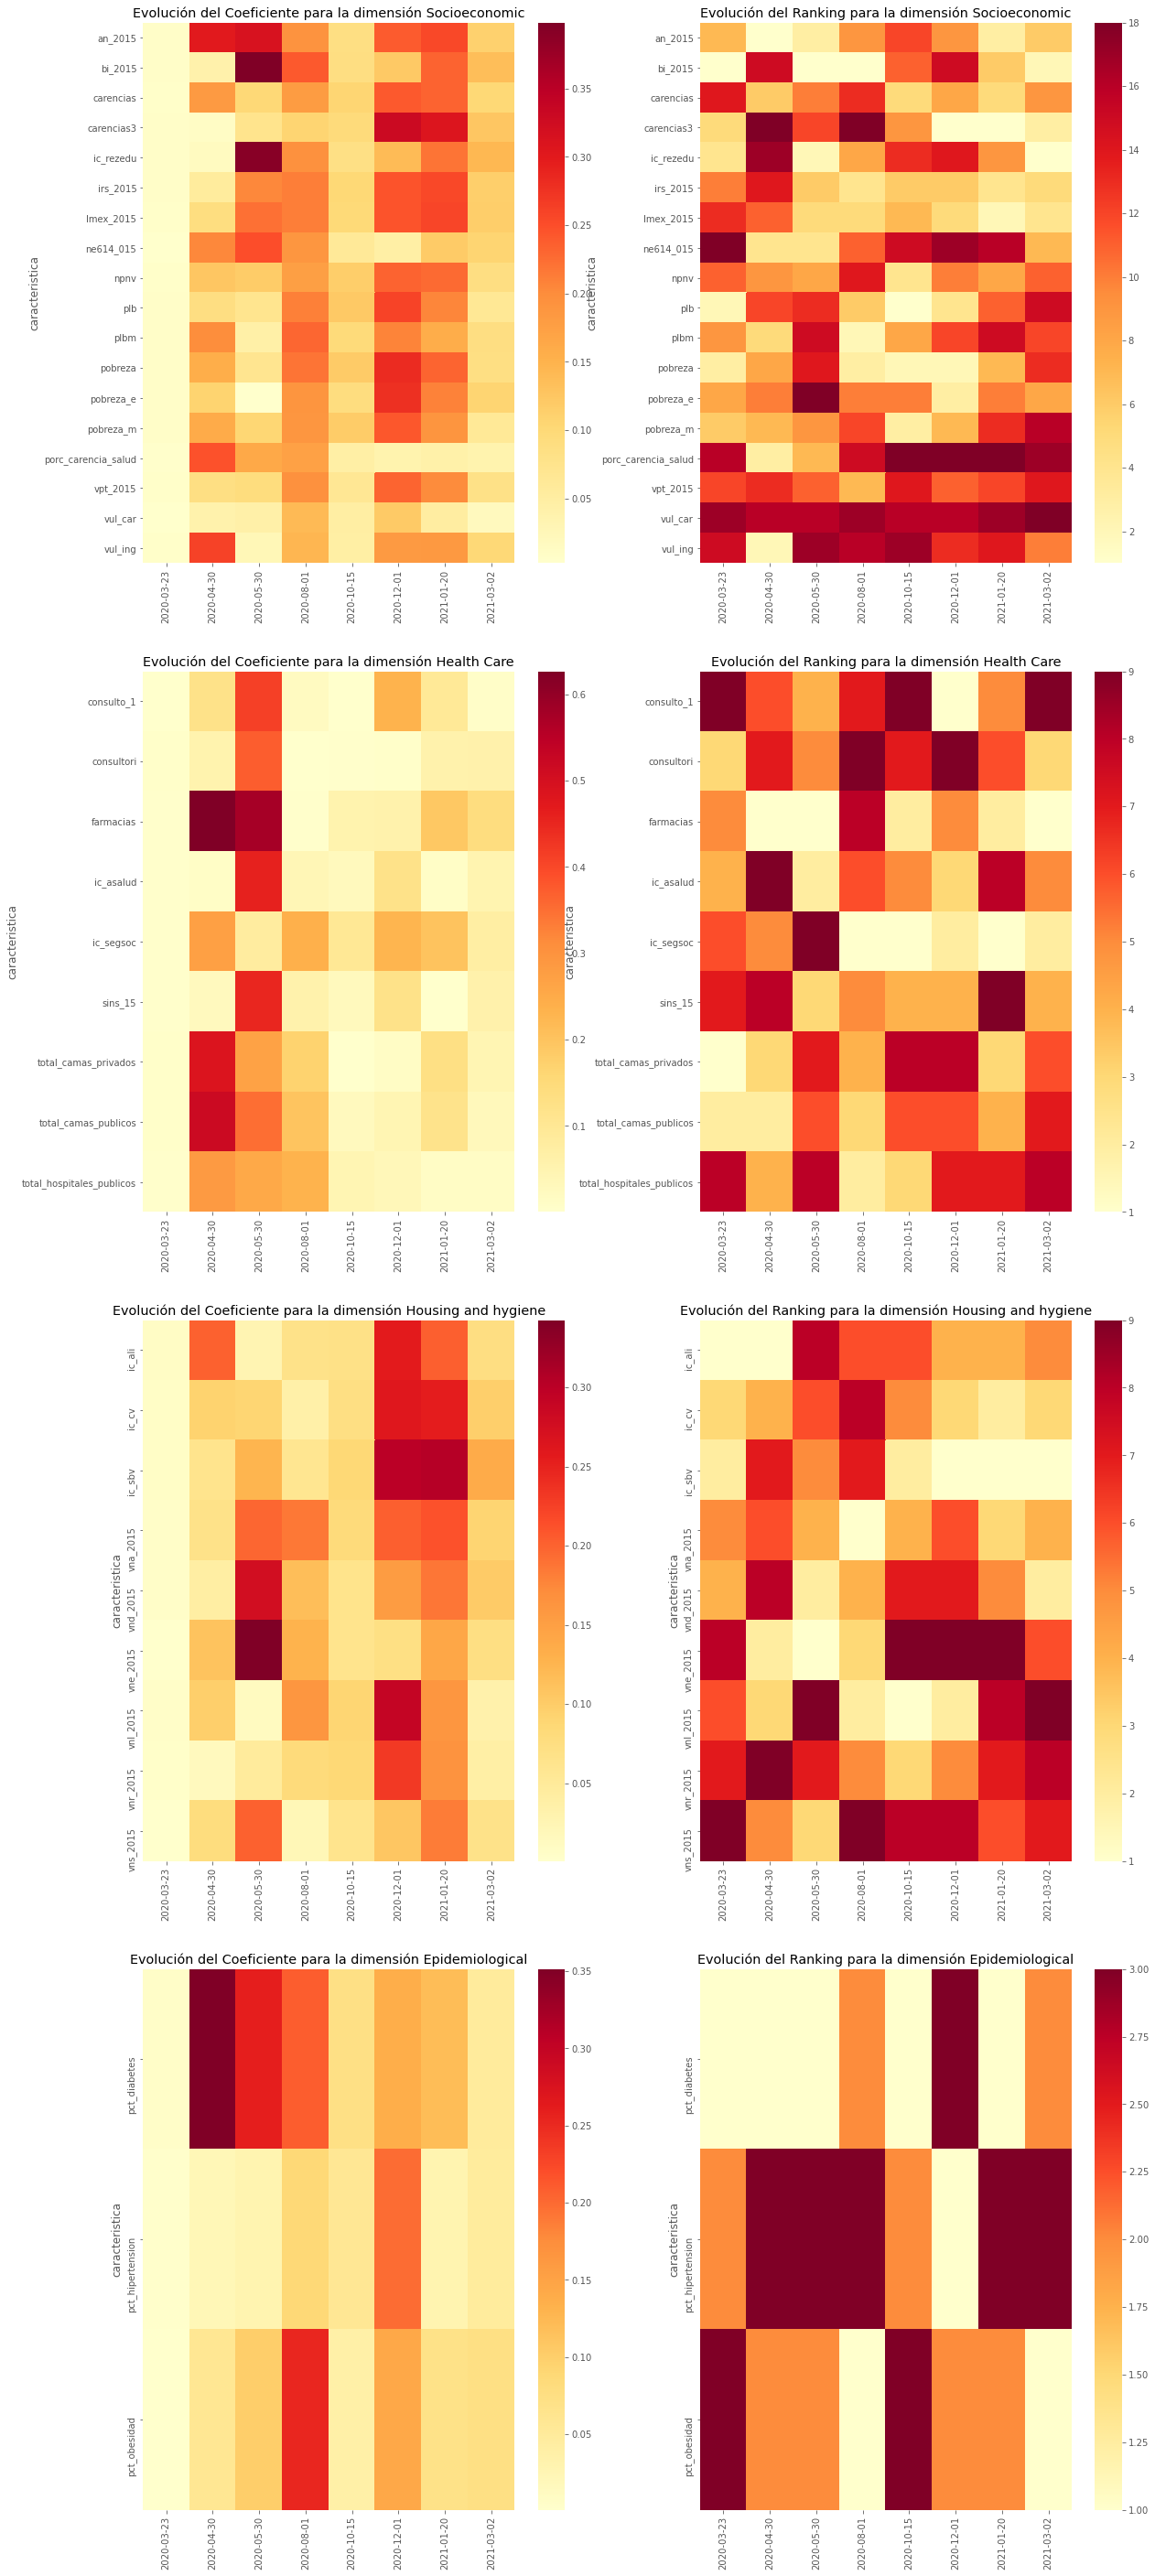

In [ ]:
lista_dimensiones = ranking_variables.dimension.unique()
modelos_momentos_wide = modelos_momentos_wide.reset_index()
new_cols = [c.strftime('%Y-%m-%d') if isinstance(c, datetime)
            else c for c in modelos_momentos_wide.columns]
modelos_momentos_wide.columns = new_cols
datos = {'Coeficiente': modelos_momentos_wide, 'Ranking': ranking_variables}
f, axes = plt.subplots(4,2,figsize=(20, 50))
#f.suptitle('Evolución de la importancia de las variables', fontsize=16)
axes = axes.ravel()
axes_count = 0
for dimension in lista_dimensiones:
    for name, df in datos.items():
        df = df[df.dimension == dimension]
        g = sns.heatmap(df.drop(columns='dimension').set_index('caracteristica'), 
                        cmap="YlOrRd", ax=axes[axes_count])
        g.set_title(f'Evolución del {name} para la dimensión {dimension}')
        axes_count += 1
#plt.tight_layout()
plt.savefig('img/heatmap_evolucion_importancias.png', bbox_inches='tight')        

### Evolución de la importancia promedio
Ahora lo mismo pero promediamos los valores por cada periodo

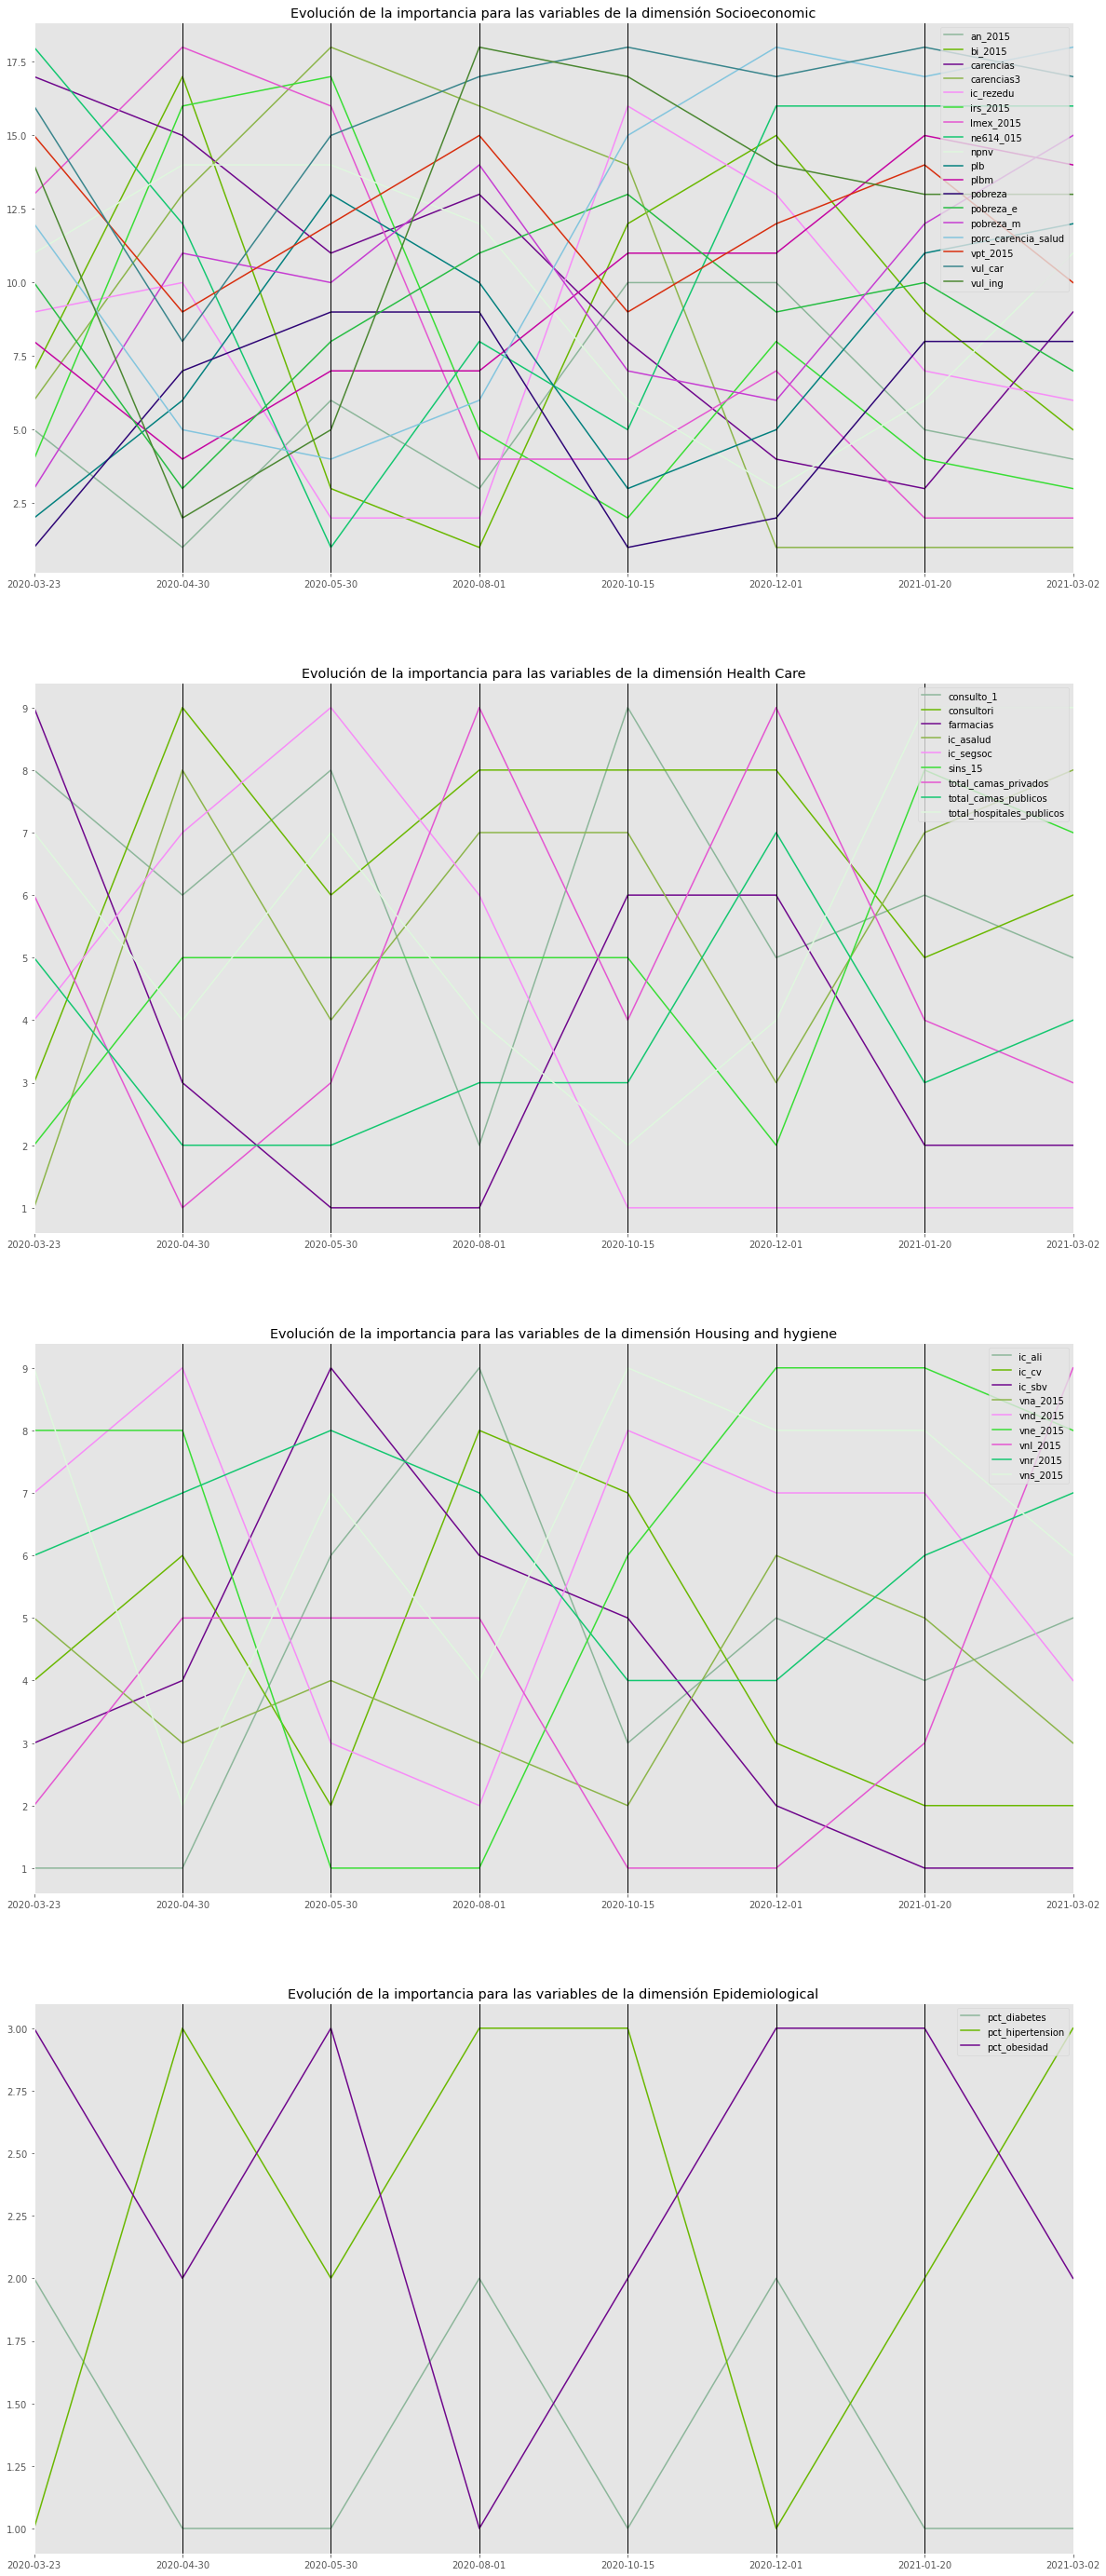

In [ ]:
for i, fecha in enumerate(fechas):
    if i == 0:
        modelos.loc[modelos.dia_ajuste <= fecha, 'intervalo'] = fecha.strftime('%Y-%m-%d')
    else:
        modelos.loc[(modelos.dia_ajuste > fechas[i-1]) & (modelos.dia_ajuste <= fecha), 'intervalo'] = fecha.strftime('%Y-%m-%d') 
modelos_momentos = modelos[modelos.dia_ajuste.isin(fechas)]
modelos['media_intervalo'] = modelos.groupby(['intervalo', 'caracteristica'])['coef'].transform('mean')
modelos_momentos = modelos_momentos.merge(dimensiones, left_on='caracteristica', right_on='campo').drop(columns=['campo', 'descriptor'])
modelos_momentos = modelos_momentos.drop(columns='coef')
modelos_momentos_wide = (modelos_momentos
                    .pivot(index=['caracteristica', 'dimension'],
                           columns='dia_ajuste',
                           values='media_intervalo')
                    )
ranking_variables = (modelos_momentos_wide
                     .groupby('dimension')
                     .rank(ascending=False)
                     .reset_index()
                     )
new_cols = [c.strftime('%Y-%m-%d') if isinstance(c, datetime)
            else c for c in ranking_variables.columns]
ranking_variables.columns = new_cols
f, axes = plt.subplots(4,figsize=(20, 50))
lista_dimensiones = ranking_variables.dimension.unique()
for i, ax in enumerate(axes):
    datos = ranking_variables[ranking_variables.dimension == lista_dimensiones[i]]
    f = pd.plotting.parallel_coordinates(datos.drop(columns="dimension"),
                                         "caracteristica",
                                         ax=ax)
    f.set_title(f'Evolución de la importancia para las variables de la dimensión {lista_dimensiones[i]}')
plt.savefig('img/evolucion_caracteristicas_por_dimension_promedio.png', bbox_inches='tight')

Heatmap

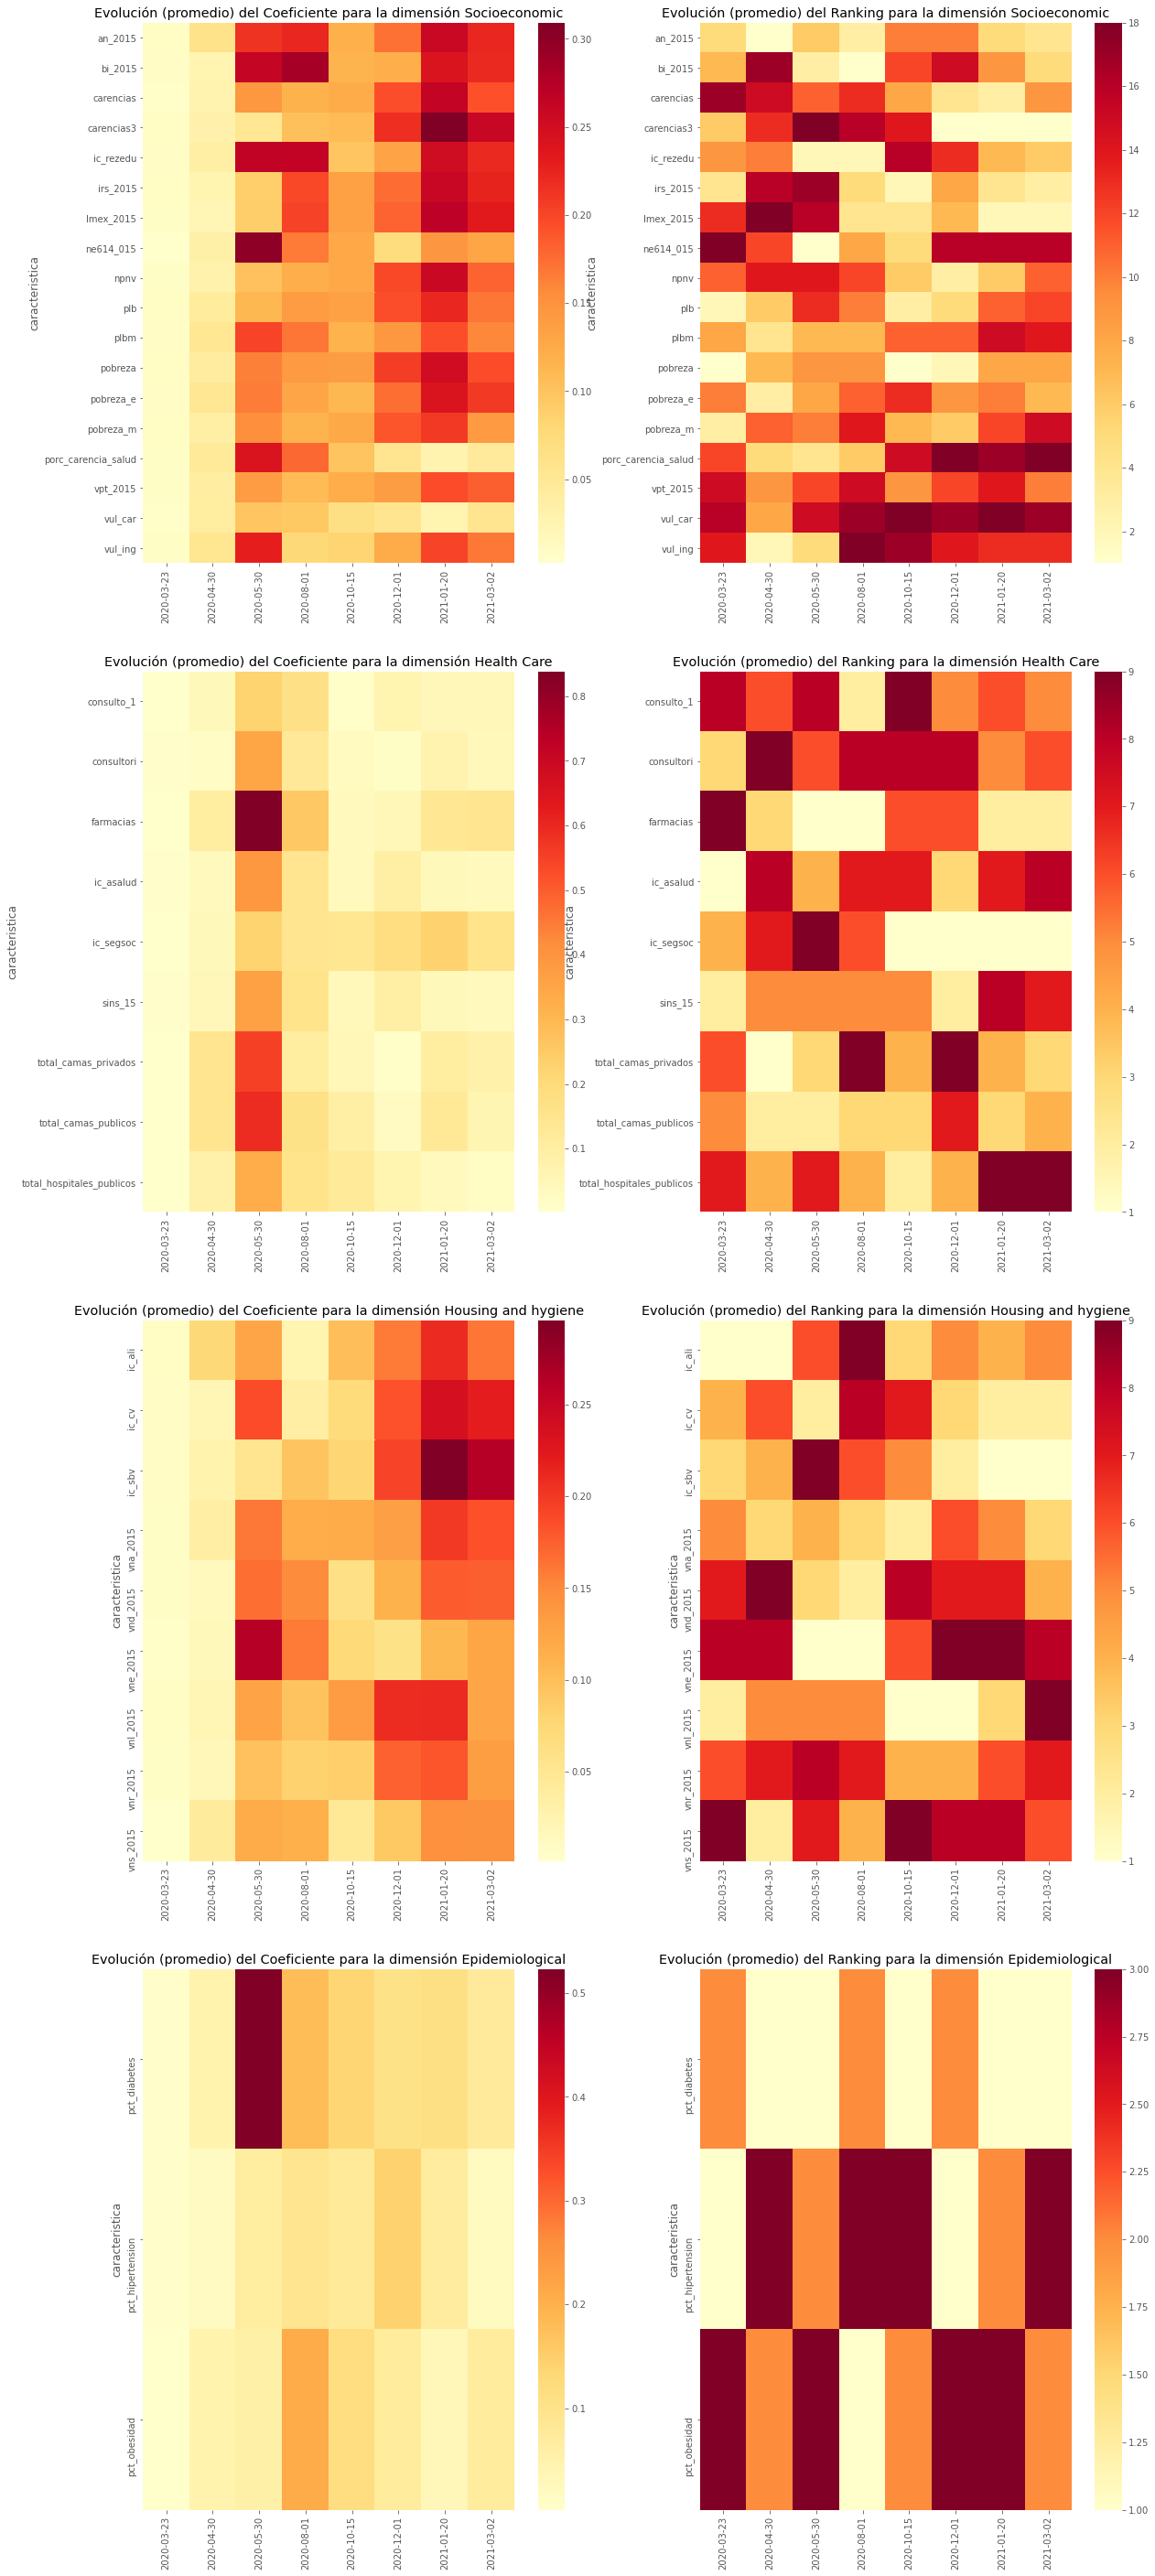

In [ ]:
modelos_momentos_wide = modelos_momentos_wide.reset_index()
new_cols = [c.strftime('%Y-%m-%d') if isinstance(c, datetime)
            else c for c in modelos_momentos_wide.columns]
modelos_momentos_wide.columns = new_cols
datos = {'Coeficiente': modelos_momentos_wide, 'Ranking': ranking_variables}
f, axes = plt.subplots(4,2,figsize=(20, 50))
#f.suptitle('Evolución de la importancia de las variables', fontsize=16)
axes = axes.ravel()
axes_count = 0
for dimension in lista_dimensiones:
    for name, df in datos.items():
        df = df[df.dimension == dimension]
        g = sns.heatmap(df.drop(columns='dimension').set_index('caracteristica'), 
                        cmap="YlOrRd", ax=axes[axes_count])
        g.set_title(f'Evolución (promedio) del {name} para la dimensión {dimension}')
        axes_count += 1
#plt.tight_layout()
plt.savefig('img/heatmap_evolucion_importancias_promediadas.png', bbox_inches='tight') 

## Mapas

Primero vamos a hacer mapas de la evolución temporal de la vulnerabilidad a nivel estado para las fechas seleccionadas.

Después mapas de la evolución a nivel municipal para todo el país y finalmente para estados seleccionables

### Estatales

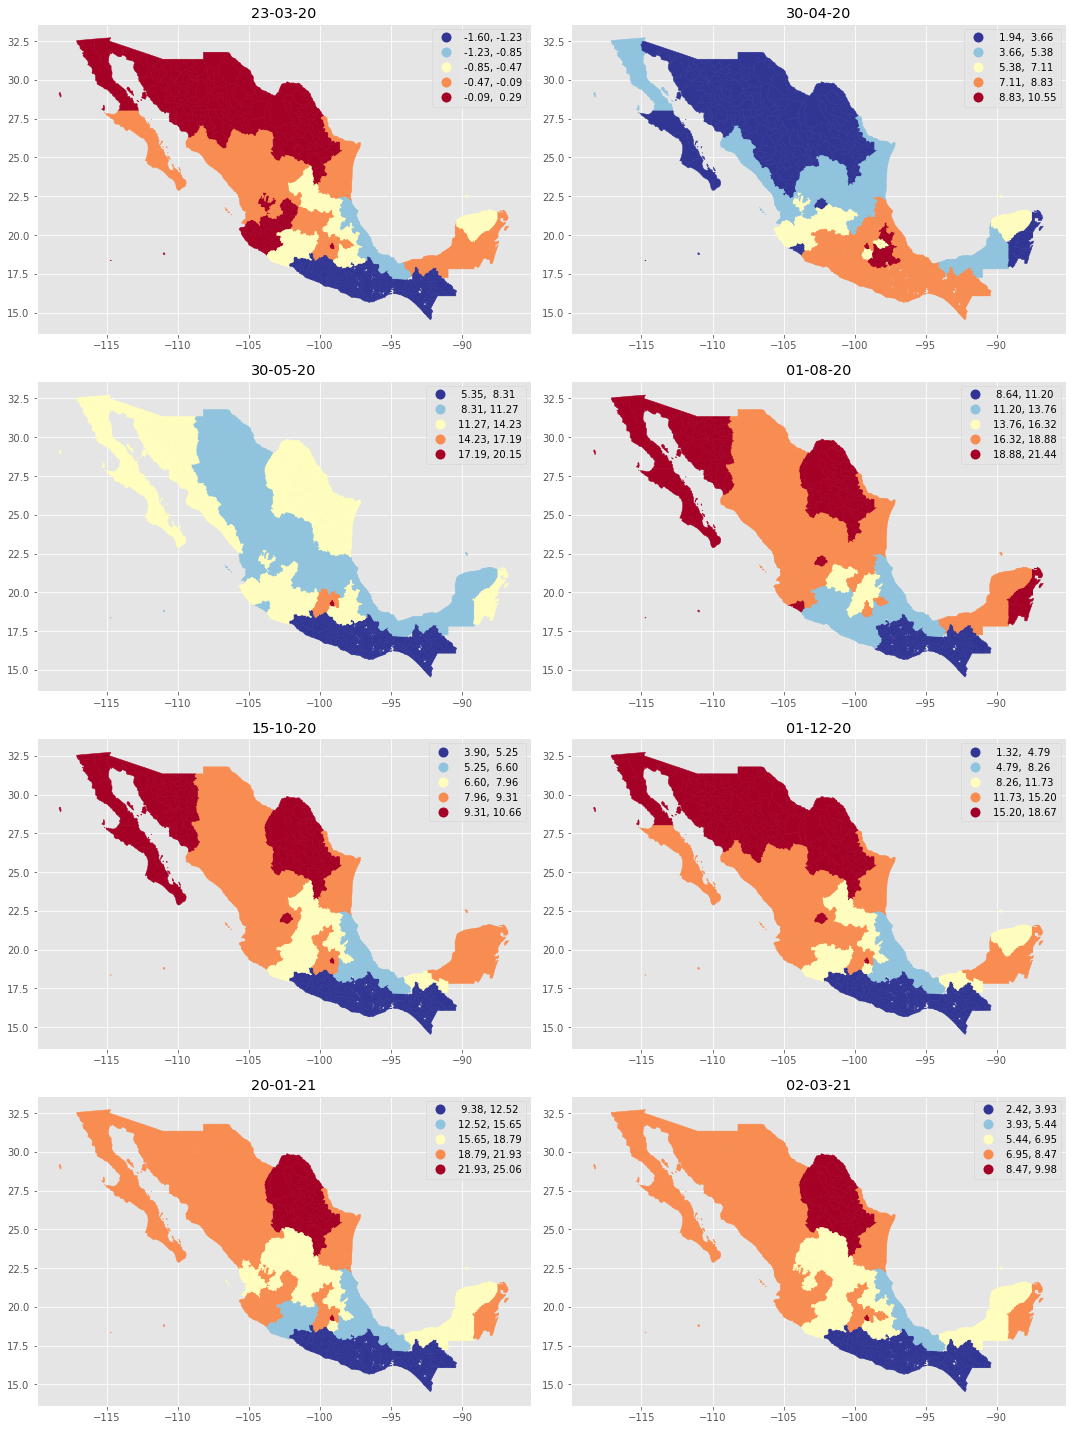

In [ ]:
fig, axes = plt.subplots(4,2,figsize=(15, 40))
axes = axes.ravel()
for i, fecha in enumerate(fechas):
    vulnerabilidad_entidad = serie[serie.FECHA_INGRESO == fecha]
    vulnerabilidad_entidad = vulnerabilidad_entidad[['ENTIDAD_RES','geometry', 'valor_covid_defun_100k_entidad']]
    f = vulnerabilidad_entidad.plot(ax=axes[i], column='valor_covid_defun_100k_entidad', cmap='RdYlBu_r',
                                    scheme="EqualInterval", legend=True, k=5,
                                    edgecolor="face")

    # remove axis of chart
    f.set_title(fecha.strftime("%d-%m-%y"))
    # position the annotation to the bottom left
    # f.annotate(fecha.strftime("%d/%m"),
    #         xy=(0.1, .225), xycoords='figure fraction',
    #         horizontalalignment='left', verticalalignment='top',
    #         fontsize=35)
fig.tight_layout()
fig.subplots_adjust(hspace=-0.8)

plt.savefig(f'img/mapa_evolucion_vulnerabilidad_entidades.png')

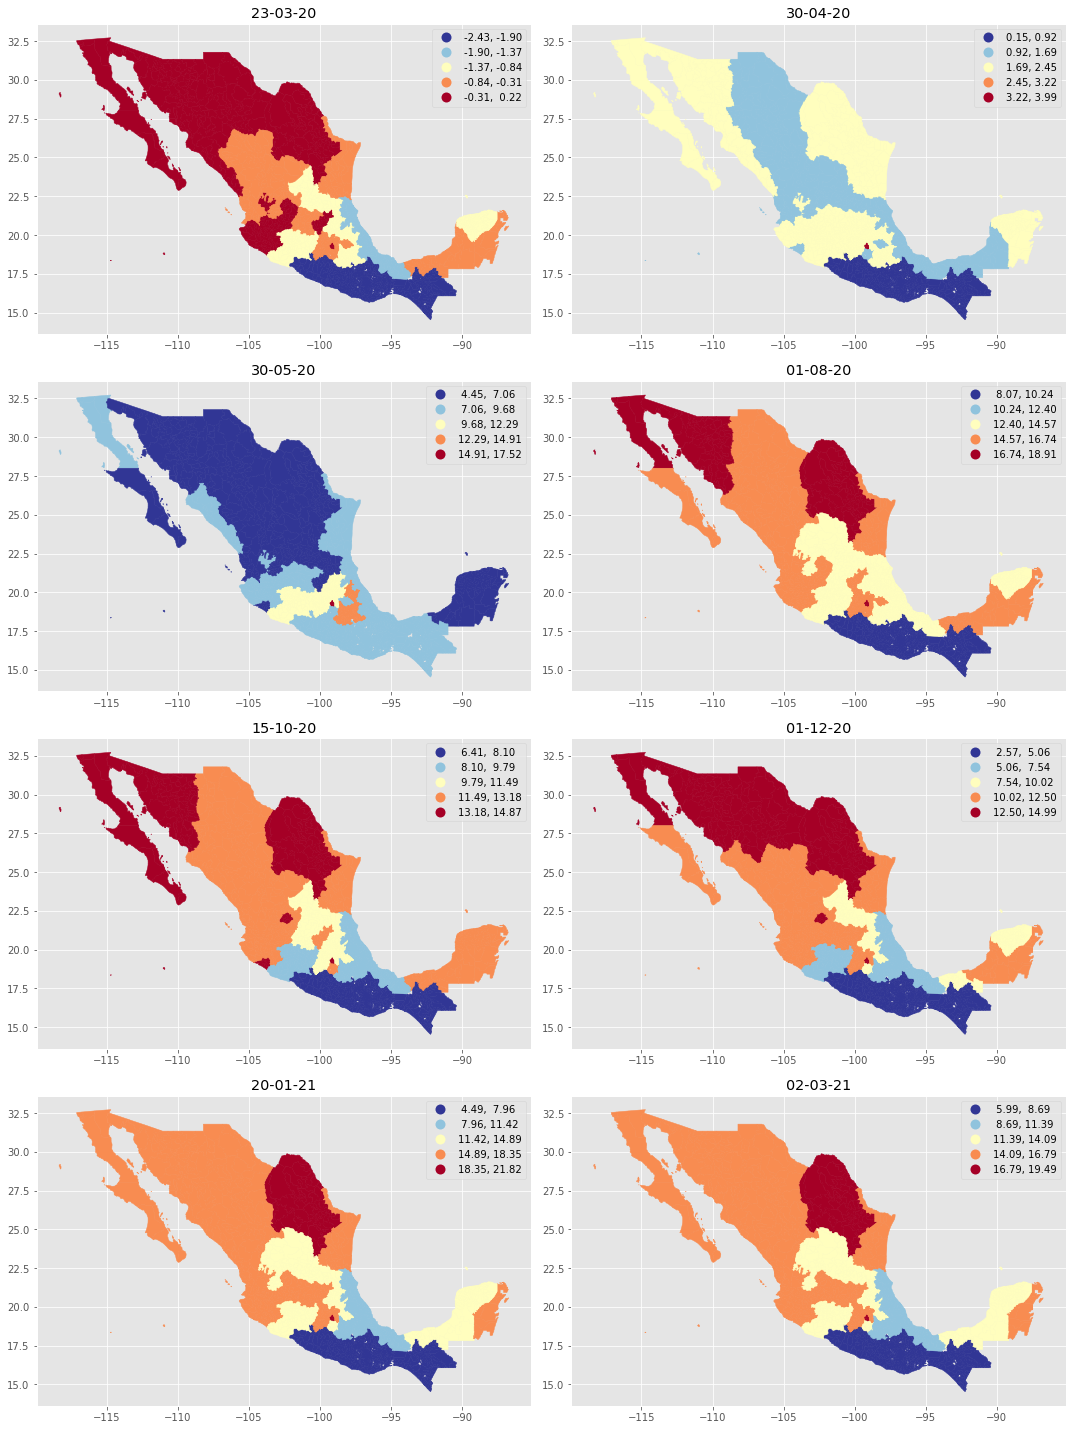

In [ ]:
fig, axes = plt.subplots(4,2,figsize=(15, 40))
axes = axes.ravel()
for i, fecha in enumerate(fechas):
    vulnerabilidad_entidad = serie[serie.FECHA_INGRESO == fecha]
    vulnerabilidad_entidad = vulnerabilidad_entidad[['ENTIDAD_RES','geometry', 'media_intervalo']]
    f = vulnerabilidad_entidad.plot(ax=axes[i], column='media_intervalo', cmap='RdYlBu_r',
                                    scheme="EqualInterval", legend=True, k=5,
                                    edgecolor="face")

    # remove axis of chart
    f.set_title(fecha.strftime("%d-%m-%y"))
    # position the annotation to the bottom left
    # f.annotate(fecha.strftime("%d/%m"),
    #         xy=(0.1, .225), xycoords='figure fraction',
    #         horizontalalignment='left', verticalalignment='top',
    #         fontsize=35)
fig.tight_layout()
fig.subplots_adjust(hspace=-0.8)
plt.savefig(f'img/mapa_evolucion_vulnerabilidad_entidades_promedio_intervalo.png')